Starting training...


Epoch 1/15: 100%|██████████| 235/235 [01:35<00:00,  2.45it/s]


Epoch 1: Loss = 0.5198, Val Acc = 0.6174, LR = 0.001000
Saved new best model


Epoch 2/15: 100%|██████████| 235/235 [01:34<00:00,  2.48it/s]


Epoch 2: Loss = 0.3176, Val Acc = 0.7096, LR = 0.001000
Saved new best model


Epoch 3/15: 100%|██████████| 235/235 [01:34<00:00,  2.48it/s]


Epoch 3: Loss = 0.3050, Val Acc = 0.8536, LR = 0.001000
Saved new best model


Epoch 4/15: 100%|██████████| 235/235 [01:34<00:00,  2.48it/s]


Epoch 4: Loss = 0.2947, Val Acc = 0.8544, LR = 0.001000
Saved new best model


Epoch 5/15: 100%|██████████| 235/235 [01:34<00:00,  2.48it/s]


Epoch 5: Loss = 0.2918, Val Acc = 0.8522, LR = 0.001000


Epoch 6/15: 100%|██████████| 235/235 [01:34<00:00,  2.48it/s]


Epoch 6: Loss = 0.2903, Val Acc = 0.6444, LR = 0.001000


Epoch 7/15: 100%|██████████| 235/235 [01:34<00:00,  2.48it/s]


Epoch 7: Loss = 0.2812, Val Acc = 0.6260, LR = 0.000500


Epoch 8/15: 100%|██████████| 235/235 [01:34<00:00,  2.48it/s]


Epoch 8: Loss = 0.2844, Val Acc = 0.8574, LR = 0.000500
Saved new best model


Epoch 9/15: 100%|██████████| 235/235 [01:34<00:00,  2.48it/s]


Epoch 9: Loss = 0.2726, Val Acc = 0.8582, LR = 0.000500
Saved new best model


Epoch 10/15: 100%|██████████| 235/235 [01:34<00:00,  2.48it/s]


Epoch 10: Loss = 0.2745, Val Acc = 0.8616, LR = 0.000500
Saved new best model


Epoch 11/15: 100%|██████████| 235/235 [01:34<00:00,  2.48it/s]


Epoch 11: Loss = 0.2747, Val Acc = 0.8600, LR = 0.000500


Epoch 12/15: 100%|██████████| 235/235 [01:34<00:00,  2.48it/s]


Epoch 12: Loss = 0.2675, Val Acc = 0.8638, LR = 0.000500
Saved new best model


Epoch 13/15: 100%|██████████| 235/235 [01:34<00:00,  2.48it/s]


Epoch 13: Loss = 0.2751, Val Acc = 0.8580, LR = 0.000500


Epoch 14/15: 100%|██████████| 235/235 [01:34<00:00,  2.48it/s]


Epoch 14: Loss = 0.2705, Val Acc = 0.8588, LR = 0.000500


Epoch 15/15: 100%|██████████| 235/235 [01:34<00:00,  2.48it/s]


Epoch 15: Loss = 0.2700, Val Acc = 0.8606, LR = 0.000250

=== Validation Set Evaluation ===


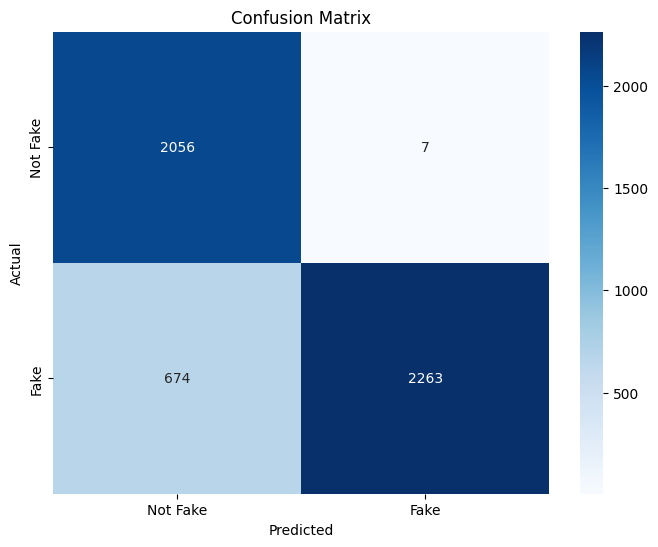

Validation Accuracy: 0.8638
Classification Report:
               precision    recall  f1-score   support

    Not Fake       0.75      1.00      0.86      2063
        Fake       1.00      0.77      0.87      2937

    accuracy                           0.86      5000
   macro avg       0.88      0.88      0.86      5000
weighted avg       0.90      0.86      0.86      5000


=== Test Set Evaluation ===


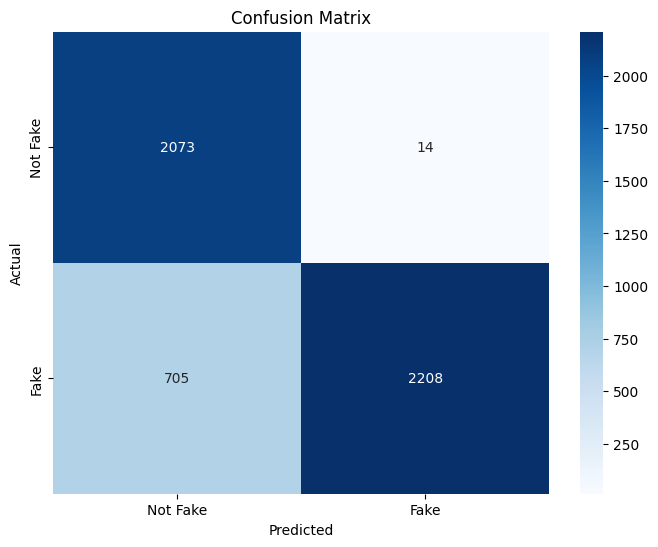

Test Accuracy: 0.8562
Classification Report:
               precision    recall  f1-score   support

    Not Fake       0.75      0.99      0.85      2087
        Fake       0.99      0.76      0.86      2913

    accuracy                           0.86      5000
   macro avg       0.87      0.88      0.86      5000
weighted avg       0.89      0.86      0.86      5000



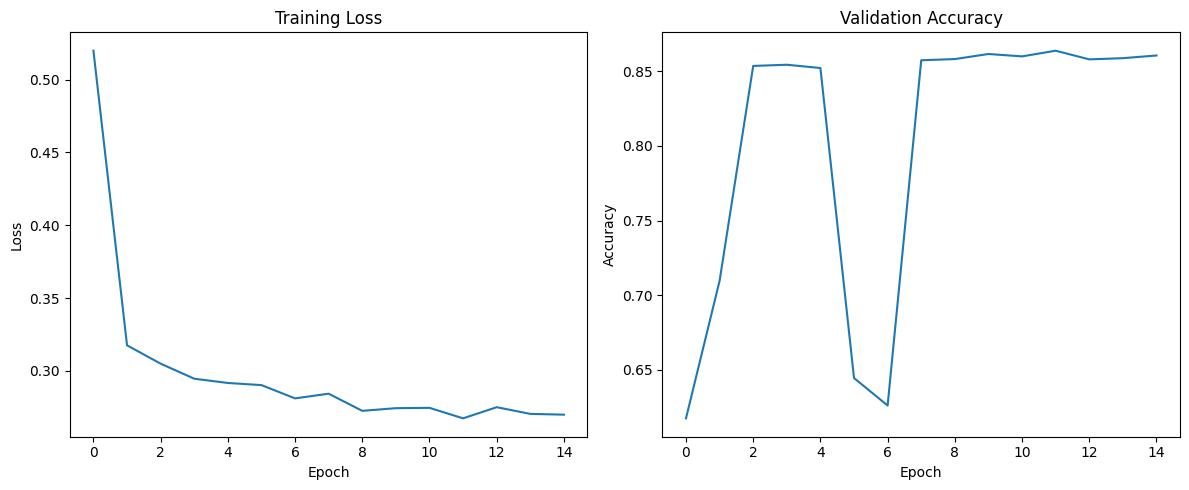

In [6]:
# ─── IMPORTS ──────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ─── DATA LOADING & PREPROCESSING (IMPROVED) ─────────────────────────────
def load_and_preprocess_data():
    # Load data with error handling
    train_df = pd.read_csv("/content/train_data.csv", engine='python', on_bad_lines='skip')
    val_df = pd.read_csv("/content/val_data.csv", engine='python', on_bad_lines='skip')
    test_df = pd.read_csv("/content/test_data.csv", engine='python', on_bad_lines='skip')

    # Enhanced text cleaning
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
        text = re.sub(r'@\w+|\#\w+', '', text)  # Remove mentions and hashtags
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
        return text

    # Label and text processing
    fake_types = ['fake', 'clickbait', 'conspiracy', 'unreliable', 'rumor', 'junksci', 'hate', 'satire']

    for df in [train_df, val_df, test_df]:
        df['label'] = df['type'].apply(lambda x: 1 if str(x).strip().lower() in fake_types else 0)
        df['text'] = df['title'].fillna('') + ' ' + df['content'].fillna('')
        df['clean_text'] = df['text'].apply(clean_text)

    return train_df, val_df, test_df

train_df, val_df, test_df = load_and_preprocess_data()

# ─── ADVANCED FEATURE ENGINEERING ────────────────────────────────────────
# 1. TF-IDF with n-grams
vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.8,
    max_features=10000,  # Increased feature space
    ngram_range=(1, 3),  # Using uni-grams, bi-grams, and tri-grams
    stop_words='english'
)

X_train = vectorizer.fit_transform(train_df['clean_text']).toarray()
X_val = vectorizer.transform(val_df['clean_text']).toarray()
X_test = vectorizer.transform(test_df['clean_text']).toarray()

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

# 2. Handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.FloatTensor(class_weights)

# ─── IMPROVED MODEL ARCHITECTURE ────────────────────────────────────────
class EnhancedCNN(nn.Module):
    def __init__(self, input_length):
        super(EnhancedCNN, self).__init__()

        # Multi-scale convolutional layers
        self.conv1 = nn.Conv1d(1, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(1, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(1, 128, kernel_size=7, padding=3)

        # Batch normalization
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(128)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )
        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(128*3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2))

    def forward(self, x):
        # Parallel convolutional paths
        x1 = self.bn1(nn.functional.relu(self.conv1(x)))
        x2 = self.bn2(nn.functional.relu(self.conv2(x)))
        x3 = self.bn3(nn.functional.relu(self.conv3(x)))

        # Apply attention
        a1 = self.attention(x1.permute(0,2,1)).permute(0,2,1)
        a2 = self.attention(x2.permute(0,2,1)).permute(0,2,1)
        a3 = self.attention(x3.permute(0,2,1)).permute(0,2,1)

        x1 = torch.sum(x1 * a1, dim=2)
        x2 = torch.sum(x2 * a2, dim=2)
        x3 = torch.sum(x3 * a3, dim=2)

        # Concatenate features
        x = torch.cat([x1, x2, x3], dim=1)

        return self.fc(x)

# ─── TRAINING SETUP WITH IMPROVEMENTS ────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1).to(device)
X_val_tensor = torch.FloatTensor(X_val).unsqueeze(1).to(device)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1).to(device)

y_train_tensor = torch.LongTensor(y_train).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Weighted sampler for imbalanced data
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

# Initialize model
model = EnhancedCNN(X_train.shape[1]).to(device)

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Optimizer with learning rate scheduling
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)

# ─── ENHANCED TRAINING LOOP ──────────────────────────────────────────────
def train_model(epochs=15):
    best_val_acc = 0
    history = {'train_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        val_acc = evaluate(val_loader)
        scheduler.step(val_acc)

        # Save history
        history['train_loss'].append(total_loss/len(train_loader))
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: Loss = {history['train_loss'][-1]:.4f}, Val Acc = {val_acc:.4f}, LR = {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("Saved new best model")

    return history

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in loader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    return correct / total

# Train the model
print("Starting training...")
history = train_model(epochs=15)

# ─── ADVANCED EVALUATION ────────────────────────────────────────────────
def full_evaluation(loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch_x, batch_y in loader:
            outputs = model(batch_x)
            probs = nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['Not Fake', 'Fake'])
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Fake', 'Fake'],
                yticklabels=['Not Fake', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return acc, report, all_probs

# Load best model
model.load_state_dict(torch.load("best_model.pth"))

print("\n=== Validation Set Evaluation ===")
val_acc, val_report, val_probs = full_evaluation(val_loader)
print(f"Validation Accuracy: {val_acc:.4f}")
print("Classification Report:\n", val_report)

print("\n=== Test Set Evaluation ===")
test_acc, test_report, test_probs = full_evaluation(test_loader)
print(f"Test Accuracy: {test_acc:.4f}")
print("Classification Report:\n", test_report)

# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


=== LIAR Validation Set Evaluation ===


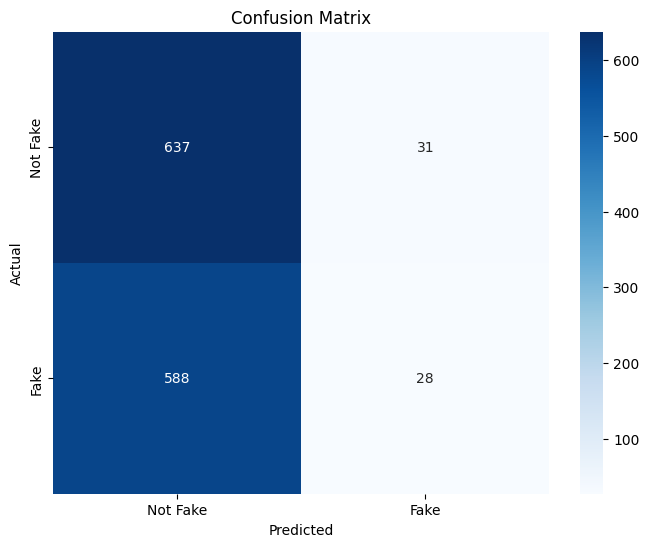

LIAR Validation Accuracy: 0.5179
Classification Report:
               precision    recall  f1-score   support

    Not Fake       0.52      0.95      0.67       668
        Fake       0.47      0.05      0.08       616

    accuracy                           0.52      1284
   macro avg       0.50      0.50      0.38      1284
weighted avg       0.50      0.52      0.39      1284


=== LIAR Test Set Evaluation ===


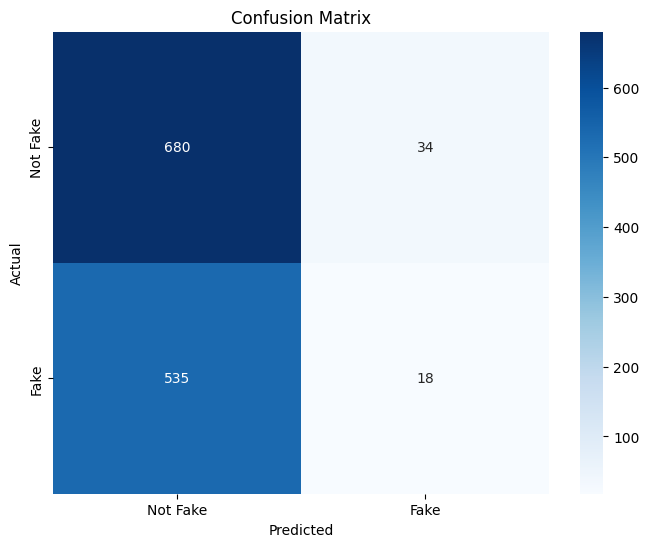

LIAR Test Accuracy: 0.5509
Classification Report:
               precision    recall  f1-score   support

    Not Fake       0.56      0.95      0.71       714
        Fake       0.35      0.03      0.06       553

    accuracy                           0.55      1267
   macro avg       0.45      0.49      0.38      1267
weighted avg       0.47      0.55      0.42      1267



In [9]:
# ─── TEXT CLEANING FUNCTION ────────────────────────────────────────────────
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|\#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# ─── RELOAD MODEL FROM DISK ────────────────────────────────────────────────
model = EnhancedCNN(X_train.shape[1]).to(device)
model.load_state_dict(torch.load("/content/best_model.pth"))
model.eval()

# ─── LOAD LIAR DATASET ─────────────────────────────────────────────────────
liar_headers = [
    "id", "label", "statement", "subject", "speaker", "job_title", "state_info", "party_affiliation",
    "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_onfire_counts", "context"
]

liar_val_df  = pd.read_csv("/content/liar/valid.tsv", sep="\t", header=None, names=liar_headers)
liar_test_df = pd.read_csv("/content/liar/test.tsv",  sep="\t", header=None, names=liar_headers)

# ─── CLEANING & LABELING ───────────────────────────────────────────────────
fake_labels = ['false', 'pants-fire', 'barely-true']
map_label = lambda x: 1 if str(x).strip().lower() in fake_labels else 0

for df in [liar_val_df, liar_test_df]:
    df['label'] = df['label'].apply(map_label)
    df['text'] = df['statement'].fillna('') + ' ' + df['context'].fillna('')
    df['clean_text'] = df['text'].apply(clean_text)

# ─── TRANSFORM TEXT USING TRAINED TF-IDF VECTORIZER ───────────────────────
X_val_liar = vectorizer.transform(liar_val_df['clean_text']).toarray()
X_test_liar = vectorizer.transform(liar_test_df['clean_text']).toarray()

y_val_liar = liar_val_df['label'].values
y_test_liar = liar_test_df['label'].values

# ─── CONVERT TO TORCH TENSORS ─────────────────────────────────────────────
X_val_tensor = torch.FloatTensor(X_val_liar).unsqueeze(1).to(device)
y_val_tensor = torch.LongTensor(y_val_liar).to(device)

X_test_tensor = torch.FloatTensor(X_test_liar).unsqueeze(1).to(device)
y_test_tensor = torch.LongTensor(y_test_liar).to(device)

val_loader_liar = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128)
test_loader_liar = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=128)

# ─── EVALUATE ON LIAR DATA ────────────────────────────────────────────────
print("\n=== LIAR Validation Set Evaluation ===")
liar_val_acc, liar_val_report, _ = full_evaluation(val_loader_liar)
print(f"LIAR Validation Accuracy: {liar_val_acc:.4f}")
print("Classification Report:\n", liar_val_report)

print("\n=== LIAR Test Set Evaluation ===")
liar_test_acc, liar_test_report, _ = full_evaluation(test_loader_liar)
print(f"LIAR Test Accuracy: {liar_test_acc:.4f}")
print("Classification Report:\n", liar_test_report)
